<h1 align="center"><font size="6"> Les méthodes de descente de gradient </font> (deuxième partie)</h1>
<hr> 

<h1>Table des matières</h1>

<div class="alert alert-block alert-info" style="margin-top : 20px">
      <ul>
          <li><a href="#prelim">Préliminaires</a></li>
          <li><a href="#Newton">La méthode de Newton</a></li>
          <li><a href="#BFGS">Une méthode de quasi-Newton (BFGS)</a></li>
      </ul>
</div>
<br>
<h>

<a id='prelim'></a>
<h2>Préliminaires</h2>
<hr>

On commence par importer les bibliothèques neecéssaires (_numpy_ et _matplotlib.pyplot_).

On définit aussi deux functions pour la visualisation de: *1/* les lignes de niveaux de la fonction ojectif et *2/* le champ de gradients (pour les fonctions objectifs dépendant de deux variables). 

Il y a aussi un exemple de graphique pour observer la vitesse de convergence des méthodes d'optimisation.

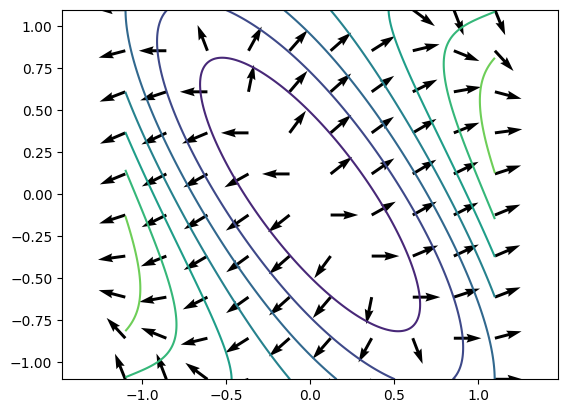

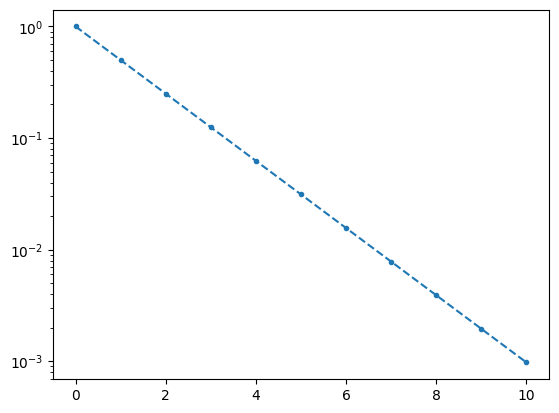

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

def draw_vector_field(F, xmin, xmax, ymin, ymax, N=15):
    X = np.linspace(xmin, xmax, N)  # x coordinates of the grid points
    Y = np.linspace(ymin, ymax, N)  # y coordinates of the grid points
    U, V = F(*np.meshgrid(X, Y))  # vector field
    M = np.hypot(U, V)  # compute the norm of (U,V)
    M[M == 0] = 1  # avoid division by 0
    U /= M  # normalize the u componant
    V /= M  # normalize the v componant
    return plt.quiver(X, Y, U, V, angles='xy')

def level_lines(f, xmin, xmax, ymin, ymax, levels, N=500):
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)
    z = f(*np.meshgrid(x, y))
    level_l = plt.contour(x, y, z, levels=levels)
    #plt.clabel(level_l, levels, fmt='%.1f') 

f = lambda x, y : np.cosh(x)+ np.sin(x + y)**2
df = lambda x, y : np.array([np.sinh(x) + 2*np.cos(x + y)*np.sin(x + y),
                             2*np.cos(x + y)*np.sin(x + y)])
%matplotlib inline
level_lines(f, -1.1, 1.1, -1.1, 1.1, np.linspace(1, 3, 10))
draw_vector_field(df, -1.1, 1.1, -1.1, 1.1, 10)
plt.axis('equal')
plt.show()

# Représentation graphique des valeurs de f au cours des itérations.
N = 10
F = 2**(-np.linspace(0,N,N+1))
plt.figure()
plt.semilogy(range(N + 1), F, '.', linestyle='dashed')
plt.show()

<a id='Newton'></a>
<h2>La méthode de Newton</h2>
<hr>

On suppose dans ce TP que $f:\mathbb{R}^N\to\mathbb{R}$ est de classe $C^2$ au moins.

La méthode de Newton (ou de Newton-Raphson) est une méthode de descente itérative dans laquelle la direction de descente à l'étape $k$ est choisie de manière à minimiser le développement limité au second ordre de $f$ au point $x^k$, c'est-à-dire
$$
\tag{4}
m_k(d):=f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T D^2 f(x^k) d.
$$
Si la matrice (symétrique) $D^2 f(x^k)$ est définie  positive le minimiseur de $m^k$ existe et est unique. On note $H^k$ l'inverse de $D^2 f(x^k)$, $g^k:=\nabla f(x^k)$ et $d^k$ le minimiseur de (4).

***Question 15.*** Exprimez $d^k$ en fonction de $H^k$ et $g^k$.

___Solution:___ 

$ d^k$ = $-H^k * g^k $

Soit $\Lambda>0$. On pose $f_\Lambda(x,y):=(1-x)^2 + \Lambda\,(y-x^2)^2$, pour $(x,y)\in\mathbb{R}^2$.  

__Question 16.__ Calculez $\nabla f_\Lambda(x,y)$. Trouves le(s) minimiseur(s) de $f_\Lambda$. Tracez quelques lignes de niveau de $f_\Lambda$ ainsi que le champ vectoriel renormalisé $(1/|\nabla f_\Lambda|)\nabla f_\Lambda$ pour $\Lambda=100$. Calculez $D^2 f(x,y)$ et son inverse $H_\Lambda(x,y)$.

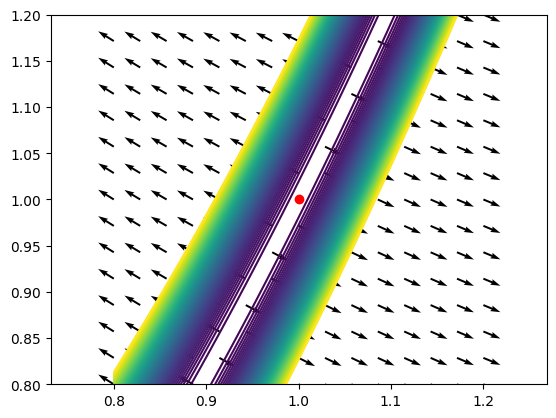

In [42]:
## Solution 
Lambda = 1000
f = lambda x,y : ( x - 1)**2 + Lambda*(y - x**2)**2
df = lambda x,y : np.array([-2*(1-x) -4*Lambda*x*(y-x**2), 2*Lambda*(y-x**2)])
ddf = lambda x,y : np.array([[4*Lambda*(3*x**2-y)+2, -4*Lambda*x], [-4*Lambda*x, 2*Lambda]])
HH = lambda x,y : 1/(4*Lambda-8*Lambda**2*(x**2+y))*np.array([[2*Lambda,4*Lambda*x],[4*Lambda*x, 4*Lambda*(x**2-y)+2]])

level_lines(f, .8, 1.2, 0.8, 1.2, np.linspace(0, 30, 80))
draw_vector_field(df, .8, 1.2, 0.8, 1.2, 15)
plt.plot(1,1,'or')
plt.axis('equal')
plt.show()

__Question 17.__ Implémentez la méthode de Newton et appliquez-la à la fonction ci-dessus avec $c=0.1$, $\beta=0.75$ et $x^0=(0,0)$. Représentez les itérations sur un graphique et tracez $\ \log(f_\Lambda(x^k))\ $ en fonction de $k$. Commentez les résultats.

_Indication:_ Testez d'abord l'algorithme sur la fonction quadratique ci-dessous.

In [43]:
# Pour le test
'''
f = lambda x,y : ( x - 1)**2 + 2*(y - 1)**2
df = lambda x,y : np.array([2*(x - 1) , 4*(y - 1)])
ddf = lambda x,y : np.array([[2  , 0], [0, 2]])
HH = lambda x,y : np.array([[.5, 0], [0, .25]])
'''
pass


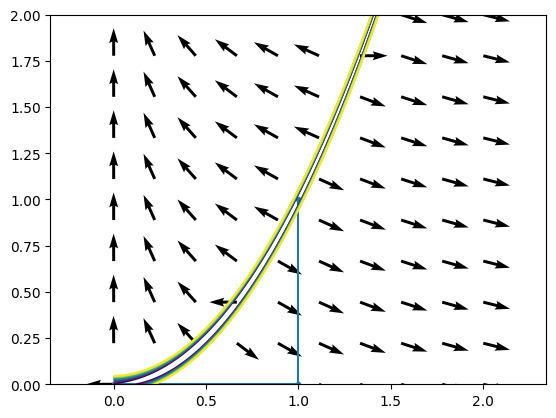

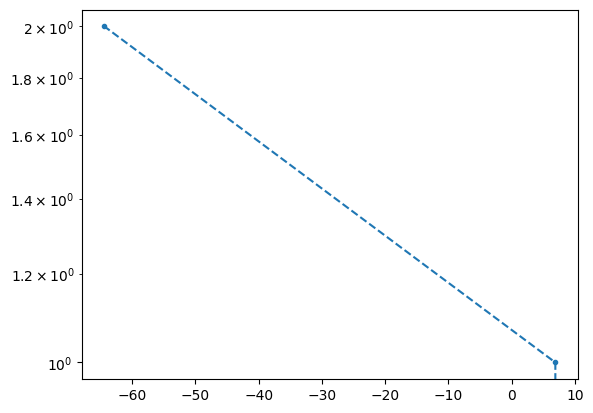

In [73]:
## Paramètres
#c, beta = .1, .75
epsilon = 1e-8
itermax = 200

# Algorithme de Newton
def newton_method(f, df, ddf, x0, max_iter=itermax, epsilon=epsilon):
    x_values = [x0]
    k = 0
    while k < max_iter:
        x_k = x_values[-1]
        d_k = -HH(*x_k)@df(*x_k)
        x_new = x_k + d_k
        
        x_values.append(x_new)
        k += 1
        
        if np.linalg.norm(df(*x_new)) < epsilon:
            break
    
    return np.array(x_values)

x0 = np.array([0,0])
W = newton_method(f, df, ddf, x0, max_iter=itermax, epsilon=epsilon)

# plot the results 
plt.figure()
plt.plot(W[:,0],W[:,1],'.',linestyle='-')
level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
draw_vector_field(df, 0 , 2, 0, 2, 10)
plt.axis('equal')
plt.show()

# Représentation graphique des valeurs de f au cours des itérations.
F = list(map(lambda x : np.log(f(*x)), W))
N = len(F)
plt.figure()
plt.semilogy(F, range(N), '.', linestyle='dashed')
plt.show()


On observe que la fonction converge vers la solution optimale (1,1) en 2 itérations et que les valeurs logarithmiques de f en x_k décroient de manière linéaire en fonction de k. 

<a id='BFGS'></a>
<h2> Une méthode de quasi-Newton (BFGS)</h2>
<hr>

Lorsque le nombre de paramètres est important comme il est habituel en Machine Learning, le calcul des matrices hessiennes $D^2f(x^k)$ et la résolution des systèmes linéaires $D^2f(x^k) d^k=-g^k$ peuvent être trop coûteux. Cependant, il est souvent encore possible d'obtenir une convergence superlinéaire en remplaçant $[D^2f(x^k)]^{-1}$ par une approximation moins gourmande à calculer qu'on notera $H^k$. Il existe plusieurs algorithmes basés sur cette idée. Nous présentons l'une des plus populaires : la méthode BFGS du nom de leurs découvreurs (Broyden, Fletcher, Goldfarb et Shanno).

__Description de la méthode__ : Supposons qu'à l'étape $k$ nous ayons une approximation définie positive symétrique $H^k$ de $\left[D^2f(x^k)\right]^{-1}$. On note $B^k$ son inverse (qui est une approximation de $D^2f(x^k)$). Comme ci-dessus, nous définissons notre direction de descente $d^k$ comme le minimiseur de
$$
f(x^k) + d\cdot \nabla f(x^k) + \dfrac12 d^T B^k d.
$$
Cela conduit à la formule :
$$
d^k = -\left[B^k\right]^{-1} \nabla f(x^k) = - H^k g^k. 
$$

On cherche ensuite $\alpha_k$ satisfaisant (5) par la méthode de ``backtracking", toujours avec $\alpha=1$ et on pose
$$
x^{k+1} := x^k +\alpha_k d^k.
$$

Maintenant, nous avons besoin de calculer approximation $H^{k+1}$ de $\left[D^2f(x^{k+1})\right]^{-1}$. Pour cela, rappelons que nous voulons
$$
\tilde m_{k+1} (d):= f(x^{k+1}) + g^{k+1}\cdot d +\dfrac 12 d^T B^{k+1} d,
$$
soit une approximation de
$$
\overline m_{k+1}(d):= f(x^{k+1} + d).
$$
Nous avons déjà par construction,
$$
\tilde m_{k+1}(0)=\overline m_{k+1}(0)=f(x^{k+1})\qquad\text{et}\qquad \nabla \tilde m_{k +1}(0)=\nabla \overline m_{k+1}(0)=g(x^{k+1}).
$$
Nous appliquons la nouvelle condition
$$
\nabla m_{k+1}(-\tau_k d^k)=\nabla \overline m_{k+1}(-\tau_k d^k)=g^k.
$$

En notant $a^k:=g^{k+1}-g^k$ et $b^k:=\tau^kd^k=x^{k+1}-x^k$, cela équivaut à $B^{k+1}b^k=a^k$. En supposant que $B^{k+1}$ est inversible, cela équivaut à demander que $H^{k+1}$ soit solution de
$$
\tag{6}
Ha^k=b^k.
$$
Une condition nécessaire et suffisante pour que (6) admette une solution symétrique définie positive $H$ est :
$$
\tag{7}
\left<a^k;b^k\right> >0.
$$

Nous ne voulons pas perdre toute l'information déjà contenue dans $H^k$, donc, en supposant que (7) soit vraie, nous choisissons une solution de (6) aussi proche que possible de $H^k$. Un choix populaire consiste à définir :
$$
\tag{8}
H^{k+1} := \left(I-\rho_k b^k\otimes a^k\right) H^k \left(I-\rho_k a^k\otimes b^k\right) + \rho_k b^k\otimes b^k,\quad\text{ avec }\quad \rho_k:=\dfrac1{\left<a^k;b^k\right>}.
$$

__Question 18.__ Vérifiez que la formule (8) donne bien une solution à (6). Vérifiez que $H^{k+1}$ ainsi définie est une matrice symétrique définie positive 

__Question 19.__ Implémentez la méthode BFGS et appliquez-la à la fonction ci-dessus avec $c = 0.1$, $\beta=0.75$ et $x^0=(0,0)$. Comme premier approximation de $D^2f(x^0)$ on prendra $H^0=I$.

Représentez les itérations sur un graphique et tracez $\ \log(f(x^k))\ $ en fonction de $k$. Observez et commentez.

__Question 20.__ Est-ce que $H^k$ converge vers $[D^2 f(x^*)]^{-1}$ ?

In [74]:
def armijo_line_search(f, grad_f, z, d, alpha_0=1, beta=0.75, c=0.5, max_iter=100):
    alpha = alpha_0
    j = 0
    while j < max_iter:
        res_1 = f(*z + alpha * d)
        res_2 = f(*z) + c * alpha * np.dot(grad_f(*z), d)
        if res_1 <= res_2:
            return alpha
        else:
            alpha *= beta
            j += 1
    return alpha

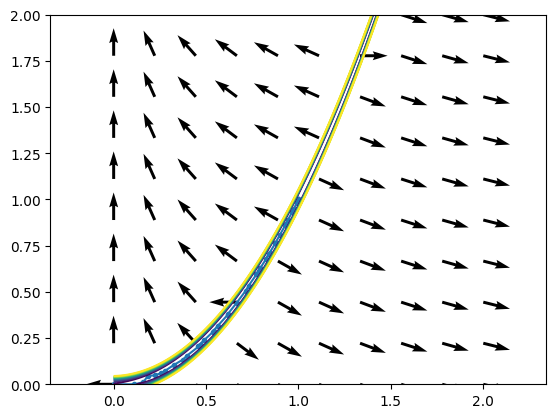

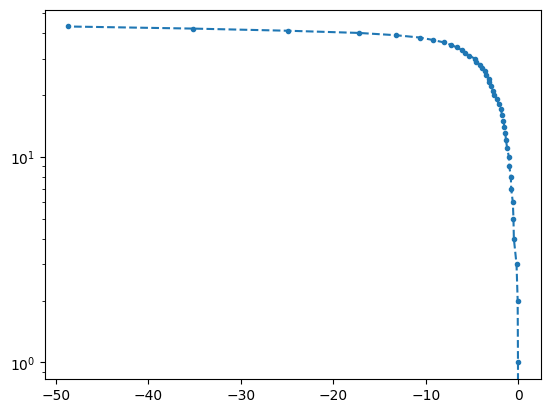

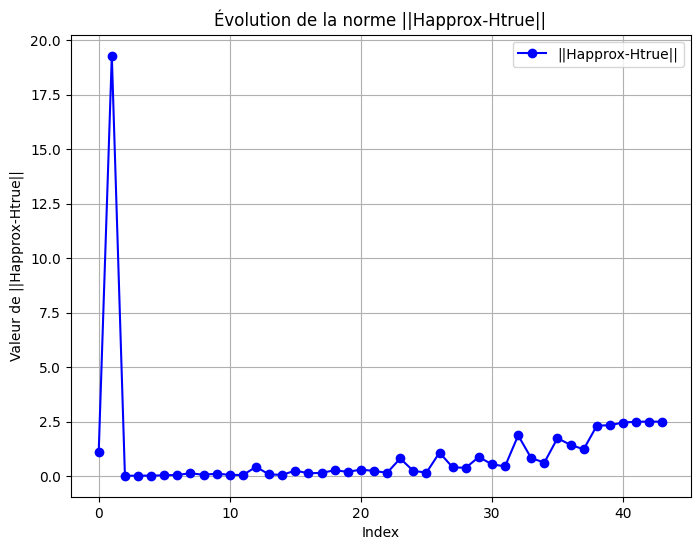

In [88]:
## Solution

## Paramètres
c, beta = .1, .75
epsilon = 1e-8
itermax = 200
iter_ls_max = 40

##
np.set_printoptions(precision=3)
np.set_printoptions(suppress="True")

## Initialisation 
x0 = np.array([0, 0])
H = np.eye(2)  

def bfgs(f, df, x0, H, max_iter=itermax, esp=epsilon):
    x_values = [x0]
    k = 0
    H_values = [np.linalg.norm(np.array(H)-np.array(HH(*x0)))]
    while k < max_iter:
        x_k = x_values[-1]
        grad = df(*x_k)
        d_k = -np.dot(H, grad)

        # Line search pour trouver la meilleure taille de pas (alpha)
        alpha_k = armijo_line_search(f, df, x_k, d_k, alpha_0=1, beta=beta, c=c, max_iter=iter_ls_max)
        
        x_new = x_k + alpha_k * d_k

        a_k = df(*x_new) - grad
        b_k = x_new - x_k

        # Mise à jour de la matrice H 
        rho_k = 1 / np.dot(a_k, b_k)
        A = np.eye(2) - rho_k * np.outer(b_k, a_k)
        B = np.eye(2) - rho_k * np.outer(a_k, b_k)
        H = np.dot(np.dot(A, H), B) + rho_k * np.outer(b_k, b_k)
        
        x_values.append(x_new)
        H_values.append(np.linalg.norm(np.array(H)-np.array(HH(*x_new))))
        k += 1
        
        if np.linalg.norm(df(*x_new)) < esp:
            break
    
    return np.array(x_values), H_values

# Représentation graphique des valeurs de f au cours des itérations
X, H_ecart = bfgs(f, df, x0, H, max_iter=itermax, esp=epsilon)

# plot the results 
plt.figure()
plt.plot(X[:,0],X[:,1],'.',linestyle='-')
level_lines(f, 0, 2, 0, 2, np.linspace(1, 3, 10))
draw_vector_field(df, 0 , 2, 0, 2, 10)
plt.axis('equal')
plt.show()

# Représentation graphique des valeurs de f au cours des itérations.
F = list(map(lambda x : np.log(f(*x)), X))
N = len(F)
plt.figure()
plt.semilogy(F, range(N), '.', linestyle='dashed')
plt.show()

# Représentation graphique des valeurs de ||Happrox-Htrue|| au cours des itérations
plt.figure(figsize=(8, 6)) 
plt.plot(range(len(H_ecart)), H_ecart, marker='o', linestyle='-', color='b', label='||Happrox-Htrue||')

plt.title('Évolution de la norme ||Happrox-Htrue||')
plt.xlabel('Index')
plt.ylabel('Valeur de ||Happrox-Htrue||')

plt.grid(True)

plt.legend()

plt.show()

On observe que la methode BFGS converge vers la solution optimal également mais recquiert d'avantage d'itérations. Le graphique des valeurs logarithmiques de f en x_k en fonction de k met en évidence cette convergence plus faible. La norme de l'écart des valeurs de la matrice H réelle et de l'estimation obtenue grace à la méthode BFGS semble converger pendant les premières itérations toutefois on observe un écart plus important à partir de 30 itérations. 